# Scaling Analysis Examples TTbar70

Authors: Brain Gravelle and Boyana Norris


All this is using the taucmdr python libraries from paratools
http://taucommander.paratools.com/

<a href='#top'>top</a><br>
<a href='#data'>Loading Data</a><br>
<a href='#metrics'>Metrics</a><br>
<a href='#corr'>Correlations</a><br>
<a href='#stl_sb'>Store Buffer Stalls</a><br>
<a href='#fetch_stalls'>Fetch Stalls</a><br>
<a href='#l3'>l3 misses</a><br>

## Imports
This section imports necessary libraies, the metrics.py and utilities.py files and sets up the window.


<a id='top'></a>

In [8]:
# A couple of scripts to set the environent and import data from a .tau set of results
from utilities import *
from metrics import *
# Plotting, notebook settings:
%matplotlib inline  
#plt.rcParams.update({'font.size': 16})
import numbers
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.2e' % x)
pd.set_option('display.max_columns',100)
pd.set_option('max_colwidth', 70)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import copy, shelve

## Getting Data
<a id='data'></a>

TAU Commander uses TAU to run the application and measure it using runtime sampling techniques (similar to Intel VTune). Many customization options are available. For example, we may consider each function regardless of calling context, or we may decide to enable callpath profiling to see each context separately.

From the talapas_scaling application the following experiments are available. These use Talapas (with 28 thread Broadwell processors) and the build-ce (realistic) option for mkFit. The first six experiments use the --num-thr option to set the thread count which is intended to perform threading within the events. the last two add the --num-ev-thr option to set the event threads, so that all threads are used to process events in parallel and each event is processed by a single thread. 
* manual_scaling_Large_talapas		
* manual_scaling_Large_talapas_fullnode	
* manual_scaling_TTbar70_talapas		
* manual_scaling_TTbar70_talapas_fullnode
* manual_scaling_TTbar35_talapas
* manual_scaling_TTbar35_talapas_fullnode
* ev_thr_scaling_Large_talapas
* ev_thr_scaling_Large_talapas_fullnode

Additionally available in the cori_scaling application are the following. These were run on NERSC's Cori on the KNL with the default memory settings (quad - 1 NUMA domain, cache - MCDRAM as direct mapped cache). See http://www.nersc.gov/users/computational-systems/cori/running-jobs/advanced-running-jobs-options/ for more info on the KNL modes. Similar to the talapas scaling they use the build-ce option and threading within each event.
* manual_scaling_TTbar35
* manual_scaling_TTbar70
* manual_scaling_Large
* mixed_thr_scaling_Large - this is bad


### Importing Scaling Data - Talapas TTbar70 is current
Here we import the data. In this case we are using Cori data from the experiments with the threads working within each event using the TTbar70 file. Note that this box will take an hour or more to run; please go enjoy a coffee while you wait.

In [9]:
#application = "talapas_scaling"
#experiment  = "manual_scaling_TTbar70_talapas_fullnode"
# experiment  = "manual_scaling_Large_talapas"
# experiment = "ev_thr_scaling_Large_talapas"

application = "cori_scaling"
# experiment  = "manual_scaling_TTbar35"
experiment  = "manual_scaling_TTbar70"
# experiment  = "manual_scaling_Large"
# experiment  = "mixed_thr_scaling_Large"

path = ".tau/" + application + "/" + experiment + "/"
# note that this function takes a long time to run, so only rerun if you must

#metric_data = get_pandas_scaling(path, callpaths=True)

metric_data = load_perf_data(application,experiment,nolibs=False,scaling=True,callpaths=True)

if False:
    if application == "talapas_scaling":
        metric_data = remove_erroneous_threads(metric_data,  [1, 8, 16, 32, 48, 56])
    elif application == "cori_scaling":
        print(metric_data.keys())
        metric_data = remove_erroneous_threads(metric_data,  [1, 4, 8, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256])

In [18]:
#metric_data_talapas_manual_scaling_TTbar70_talapas_fullnode = metric_data
#metric_data_cori_manual_scaling_TTbar70=metric_data

## Adding metrics
<a id='metrics'></a>

metrics are available in metrics.py. At this time the following can be added:
* add_IPC(metrics)          - Instructions per Cycle
* add_CPI(metrics)          - Cycles per instruction
* add_VIPC(metrics)         - vector instructions per cycle
* add_VIPI(metrics)         - vector instructions per instruction (i.e. fraction of total)
* add_L1_missrate(metrics)  - miss rate for L1 cache

for scaling data please use the add_metric_to_scaling_data(data, metric_func) function to add a metric

Here we add some predeefined metrics and print the top 10 functions with the best IPC

In [10]:
add_metric_to_scaling_data(metric_data, add_CPI)
add_metric_to_scaling_data(metric_data, add_IPC)
add_metric_to_scaling_data(metric_data, add_StallPercent)
add_metric_to_scaling_data(metric_data, add_L1_missrate)
add_metric_to_scaling_data(metric_data, add_L2_missrate)
add_metric_to_scaling_data(metric_data, add_VIPC)
#add_metric_to_scaling_data(metric_data, add_DERIVED_SP_VOPO)

if application == 'cori_scaling': 
    llc = True
    add_metric_to_scaling_data(metric_data, add_VIPI)
else: 
    llc = False
#     add_metric_to_scaling_data(metric_data, add_DERIVED_SP_VOPO)
    
add_metric_to_scaling_data(metric_data, add_L3_missrate, llc)
add_metric_to_scaling_data(metric_data, add_DERIVED_BRANCH_MR)

print_available_metrics(metric_data, scaling=True)
print(metric_data.keys())
# To test
# metric_data[32]['DERIVED_SP_VOPO'].sort_values(by='Exclusive',ascending=False).head(10)

ERROR adding CPI to metric dictionary
ERROR adding metric to thread count: 32
ERROR adding IPC to metric dictionary
ERROR adding metric to thread count: 32
ERROR adding StallPercent to metric dictionary
ERROR adding metric to thread count: 32
ERROR adding VecEfficiency to metric dictionary
ERROR adding metric to thread count: 32
ERROR adding VecEfficiency to metric dictionary
ERROR adding metric to thread count: 32
DERIVED_VIPI
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD
PAPI_L2_TCA
PAPI_NATIVE_LLC_MISSES
PAPI_TLB_DM
DERIVED_VIPC
PAPI_L2_TCM
PAPI_NATIVE_FETCH_STALL
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD
DERIVED_CPI
PAPI_L1_TCM
PAPI_BR_MSP
PAPI_RES_STL
PAPI_TOT_INS
PAPI_BR_CN
DERIVED_L1_MISSRATE
DERIVED_L3_MISSRATE
PAPI_BR_UCN
PAPI_NATIVE_LLC_REFERENCES
PAPI_BR_INS
DERIVED_L2_MISSRATE
DERIVED_STALL_PERCENT
DERIVED_BRANCH_MR
DERIVED_IPC
PAPI_LST_INS
PAPI_NATIVE_RS_FULL_STALL
PAPI_TOT_CYC
[128, 1, 240, 48, 80, 32, 8, 64, 144, 176, 192, 224, 96, 16, 112, 256, 160, 208]


#### Combining metrics

In [11]:
THREAD_COUNT = 256

alldata = combine_metrics(metric_data[THREAD_COUNT],inc_exc='Exclusive')
alldata.head()

PAPI_TOT_CYC  \
thread region                                                                                 
0      [SUMMARY] .TAU application                                                  0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                   0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      1.52e+09   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      1.43e+07   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      8.53e+07   

                                                                               DERIVED_VIPI  \
thread region                                                                                 
0      [SUMMARY] .TAU application                                                       nan   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                        nan   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      1.47e-01   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...           nan   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...      1.49e-01   

                                                                               PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD  \
thread region                                                                                                         
0      [SUMMARY] .TAU application                                                                          0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                                           0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...                              4.27e+08   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...                              1.69e+06   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...                              6.24e+06   

                                                                               PAPI_L2_TCA  \
thread region                                                                                
0      [SUMMARY] .TAU application                                                 0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                  0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...     1.59e+07   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...     5.16e+05   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...     2.52e+06   

                                                                               PAPI_NATIVE_LLC_MISSES  \
thread region                                                                                           
0      [SUMMARY] .TAU application                                                            0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                             0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...                4.89e+05   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...                1.48e+04   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...                2.27e+05   

                                                                               PAPI_TLB_DM  \
thread region                                                                                
0      [SUMMARY] .TAU application                                                 0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application                  0.00e+00   
       [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...     1.30e+06   
       [SUMMARY] .TAU application  => [CONTEXT] 

## Scaling Results

In this section we carefully walk through an analysis of the application to find areas of interest.

We begin by looking at correlations of data to determine metrics of interest and then move on to ploting those metric. In this analysis we primarily use PAPI_TOT_CYC as a proxy for the time it takes a function to complete.

## Correlations
<a id='corr'></a>

In [174]:
names={'PAPI_TOT_CYC':'Total Cycles',
'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD':'Vector operations',
'PAPI_L2_TCA' : 'L2 accesses',
'PAPI_NATIVE_LLC_MISSES' : 'L3 total cache misses',
'PAPI_NATIVE_LLC_REFERENCES' : 'L3 accesses',
'PAPI_TLB_DM' : 'TLB data misses',
'PAPI_BR_MSP' : 'Branch mispredictions',
'PAPI_L1_TCM' : 'L1 total cache misses',
'PAPI_L2_TCM' : 'L2 total cache misses',
'PAPI_LST_INS' : 'Load/store instructions',
'PAPI_BR_CN' : 'Conditional branches',
'PAPI_TOT_INS' : 'Total instructions',
'PAPI_BR_INS' : 'Branch instructions',
'PAPI_BR_UCN' : 'Unconditional branches',
'PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD' : 'Scalar vector ops',
'PAPI_RES_STL' : 'Total resource stalls (cycles)',
'PAPI_NATIVE_FETCH_STALL':'Number of cycles stalled for instruction cache miss',
'PAPI_NATIVE_RS_FULL_STALL' : 'Resource stalls',
'DERIVED_STALL_PERCENT' : 'Fraction of total stalls',
'DERIVED_L1_MISSRATE' : 'L1 miss rate',
'DERIVED_L3_MISSRATE' : 'L3 miss rate',
'DERIVED_BRANCH_MR' : 'Branch misprediction rate',
'DERIVED_IPC' : 'Instructions per cycle',
'DERIVED_CPI' : 'Cycles per instruction',
'DERIVED_VIPI' : 'Vector instructions fraction',
'DERIVED_VIPC' :'Vector instructions per cycle',
'Other' : 'Other'
}

In [17]:
cm = sns.light_palette("yellow", as_cmap=True)

def get_corr(alldata, method='pearson', metrics=['PAPI_RES_STL','PAPI_TOT_CYC','DERIVED_STALL_PERCENT']):
    correlations = alldata.corr(method).fillna(0)[metrics]    # Other methods: 'kendall', 'spearman'
    correlations = correlations[correlations['PAPI_RES_STL']>.5].sort_values(by='PAPI_RES_STL',ascending=False)
    correlations.insert(0, 'Metric',pd.Series(names))
    fmt = correlations.select_dtypes(exclude=['object']).style.format("{:.2%}").background_gradient(cmap=cm)
    return correlations
    
pcorr = get_corr(alldata)
kcorr = get_corr(alldata, method='kendall')
scorr = get_corr(alldata, method='spearman')
scorr.style.background_gradient(cmap=cm)
print(scorr.to_csv(sep='\t'))

,Metric,PAPI_RES_STL,PAPI_TOT_CYC,DERIVED_STALL_PERCENT
PAPI_RES_STL,Total resource stalls (cycles),1,0.817602,0.497055
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,Scalar operations using vector units,0.860079,0.827811,0.275644
PAPI_NATIVE_RS_FULL_STALL,Resource stalls,0.847566,0.817486,0.282238
PAPI_BR_CN,Conditional branches,0.81925,0.777036,0.293528
PAPI_TOT_CYC,Total Cycles,0.817602,1,-0.10519
PAPI_NATIVE_LLC_MISSES,L3 misses,0.811967,0.772483,0.298891
PAPI_BR_INS,Branch instructions,0.806654,0.770041,0.274309
PAPI_BR_MSP,Branch mispredictions,0.79815,0.749906,0.277938
PAPI_LST_INS,Load/store instructions,0.796757,0.745954,0.305518
PAPI_NATIVE_LLC_REFERENCES,L3 accesses,0.786111,0.739938,0.280785


	Metric	PAPI_RES_STL	PAPI_TOT_CYC	DERIVED_STALL_PERCENT
PAPI_RES_STL	Total resource stalls (cycles)	1.0	0.81760207488	0.497055190538
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD	Scalar operations using vector units	0.860078691482	0.82781109519	0.275643607633
PAPI_NATIVE_RS_FULL_STALL	Resource stalls	0.847565577404	0.817486122333	0.282238199097
PAPI_BR_CN	Conditional branches	0.819249973835	0.777035735033	0.293528484781
PAPI_TOT_CYC	Total Cycles	0.81760207488	1.0	-0.105189513937
PAPI_NATIVE_LLC_MISSES	L3 misses	0.811966927584	0.772482694058	0.298890776116
PAPI_BR_INS	Branch instructions	0.80665443065	0.770041067766	0.274308648833
PAPI_BR_MSP	Branch mispredictions	0.79814998813	0.74990628091	0.277937556328
PAPI_LST_INS	Load/store instructions	0.796757449543	0.745953792	0.305517838425
PAPI_NATIVE_LLC_REFERENCES	L3 accesses	0.786111410967	0.739937826089	0.280784750319
PAPI_TOT_INS	Total instructions	0.785482405308	0.733982418102	0.296335827342
PAPI_L2_TCM	L2 total cache misses	0.778419591048	0.738

In [7]:
metric_li = ['PAPI_TOT_CYC','PAPI_RES_STL']

corrs = [alldata.corr('pearson').fillna(0)[metric_li], alldata.corr('kendall').fillna(0)[metric_li], alldata.corr('spearman').fillna(0)[metric_li]]

corr_data = corrs[0][['PAPI_TOT_CYC']].copy()
corr_data['p_' + metric_li[0]] = corr_data[metric_li[0]]
corr_data['p_' + metric_li[1]] = corrs[0][metric_li[1]]

corr_data['k_' + metric_li[0]] = corrs[1][metric_li[0]]
corr_data['k_' + metric_li[1]] = corrs[1][metric_li[1]]

corr_data['s_' + metric_li[0]] = corrs[2][metric_li[0]]
corr_data['s_' + metric_li[1]] = corrs[2][metric_li[1]]

corr_data.drop(['PAPI_TOT_CYC'],axis=1,inplace=True)

corr_data.style.format("{:.2%}").background_gradient(cmap=cm)

,p_PAPI_TOT_CYC,p_PAPI_RES_STL,k_PAPI_TOT_CYC,k_PAPI_RES_STL,s_PAPI_TOT_CYC,s_PAPI_RES_STL
PAPI_TOT_CYC,100.00%,19.87%,100.00%,41.42%,100.00%,54.54%
DERIVED_VIPI,-5.70%,-15.64%,8.64%,-5.14%,13.95%,-7.07%
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,21.39%,13.71%,42.85%,62.16%,56.68%,78.70%
PAPI_L2_TCA,78.98%,46.50%,49.99%,66.34%,65.06%,83.82%
PAPI_NATIVE_LLC_MISSES,80.35%,57.14%,48.73%,67.42%,63.40%,84.74%
PAPI_TLB_DM,83.06%,41.72%,49.30%,63.02%,64.59%,80.27%
PAPI_L2_TCM,80.02%,57.00%,48.10%,64.86%,62.96%,82.19%
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,81.76%,26.10%,53.12%,62.45%,68.56%,77.99%
PAPI_NATIVE_FETCH_STALL,87.10%,24.26%,50.02%,58.79%,65.36%,75.70%
PAPI_L1_TCM,80.82%,56.13%,48.79%,63.05%,63.64%,80.57%


### Correlation Take Aways

At first glance the correlations seem to show that cache misses (although not necessarily the miss rates) are significantly related to the numebr of stalls that occur.

### Stalls as percentage of total

In [65]:
# data cleanup
metric_data[48]['PAPI_TOT_CYC'].head(20)

Calls  \
context thread region                                                                            
0       0      [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I... 2.75e+00   
               [SUMMARY] .TAU application                                             1.63e+03   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application              1.63e+03   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.75e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 3.18e+02   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.25e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.50e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.12e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.75e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 4.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.25e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 9.50e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 7.75e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 2.30e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 3.25e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 1.02e+01   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP... 4.25e+00   

                                                                                       Exclusive  \
context thread region                                                                              
0       0      [SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::I...   1.07e+07   
               [SUMMARY] .TAU application                                               0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application                0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.07e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.45e+08   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.36e+06   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.02e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.14e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.88e+06   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.70e+06   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   3.70e+06   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   0.00e+00   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   1.03e+07   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   7.04e+06   
               [SUMMARY] .TAU application  => [CONTEXT] .TAU application  => [SAMP...   2.00e+07   
               [SUMMARY] .TAU ap

In [19]:
mdata = {}
mdata_perc = {}
for k,v in metric_data.items():
    if k==1: continue
    mdata[k] = metric_data[k]  #_talapas_manual_scaling_TTbar70_talapas_fullnode


ERROR getting PAPI_TOT_CYC for thread 32


Text(0.5,0,u'Number of Threads')

Text(0,0.5,u'PAPI_TOT_CYC')

ERROR getting PAPI_TOT_CYC for thread 32
Threads= 8
Threads= 16
Threads= 48
Threads= 64
Threads= 80
Threads= 96
Threads= 112
Threads= 128
Threads= 144
Threads= 160
Threads= 176
Threads= 192
Threads= 208
Threads= 224
Threads= 240
Threads= 256
[8, 16, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 256]


Text(0.5,0,u'Difference in total cycles between 8 and 256 threads')

region
[SUMMARY] MkBuilder::map_seed_hits()                                                                                                                                               -2.60e+06
[SUMMARY] Hit::Hit()                                                                                                                                                               -1.58e+05
[SUMMARY] Matriplex::Matriplex<float, 1, 1, 8>::operator[](int)                                                                                                                    -2.14e+04
[SUMMARY] LayerInfo::is_within_r_sensitive_region(float, float) const                                                                                                               3.77e+04
[SUMMARY] RadixSort::Sort(float const*, unsigned int)                                                                                                                               6.39e+04
[SUMMARY] (anonymous namespace)::MultHelixProp(M

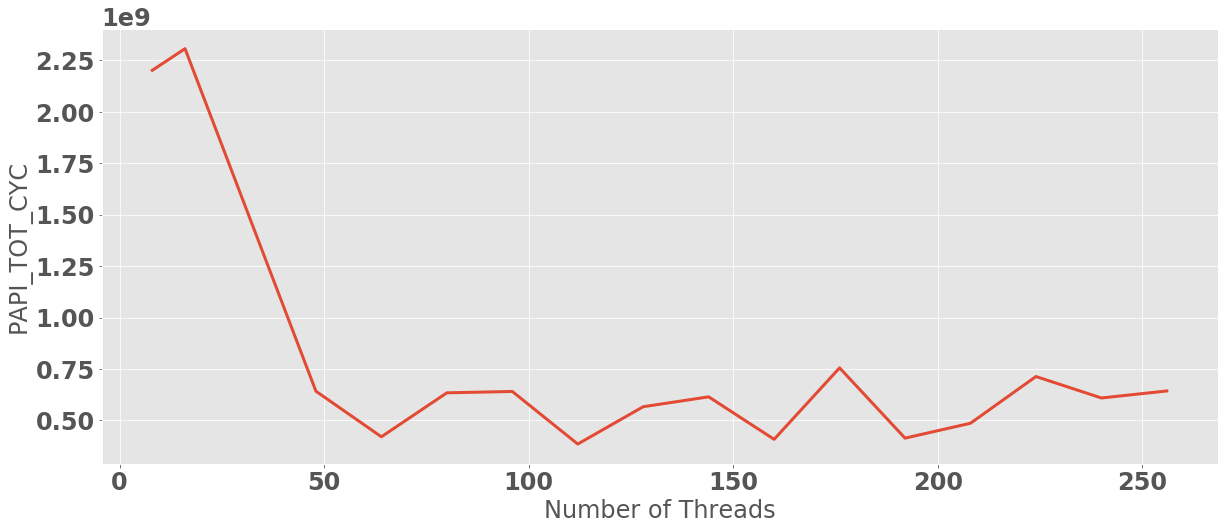

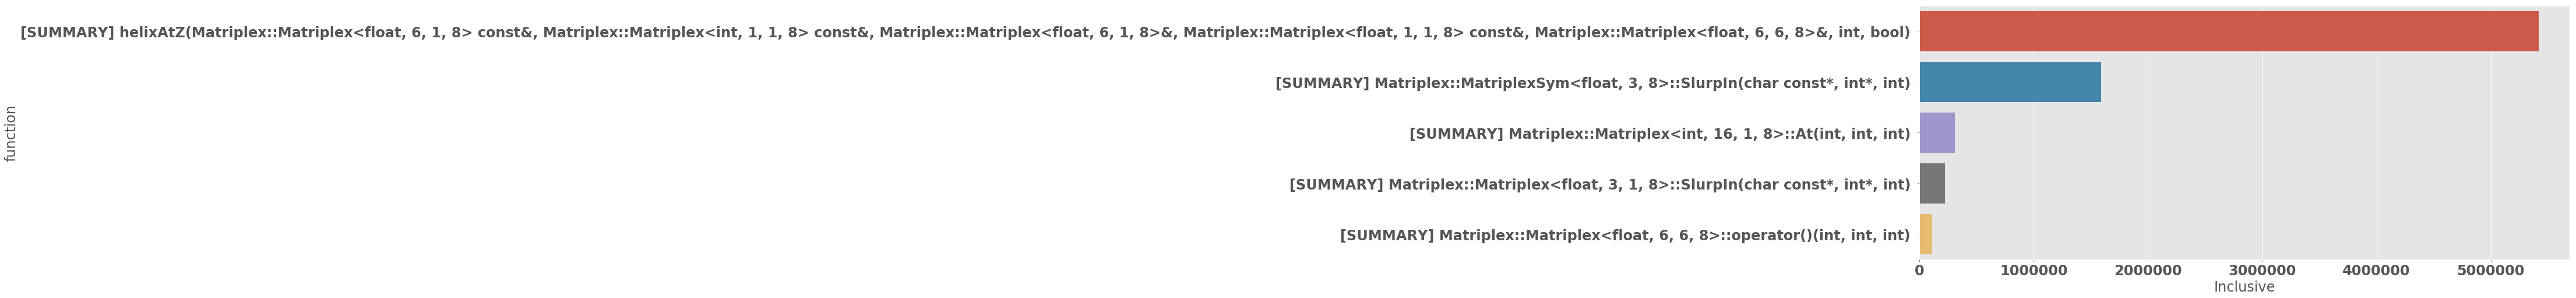

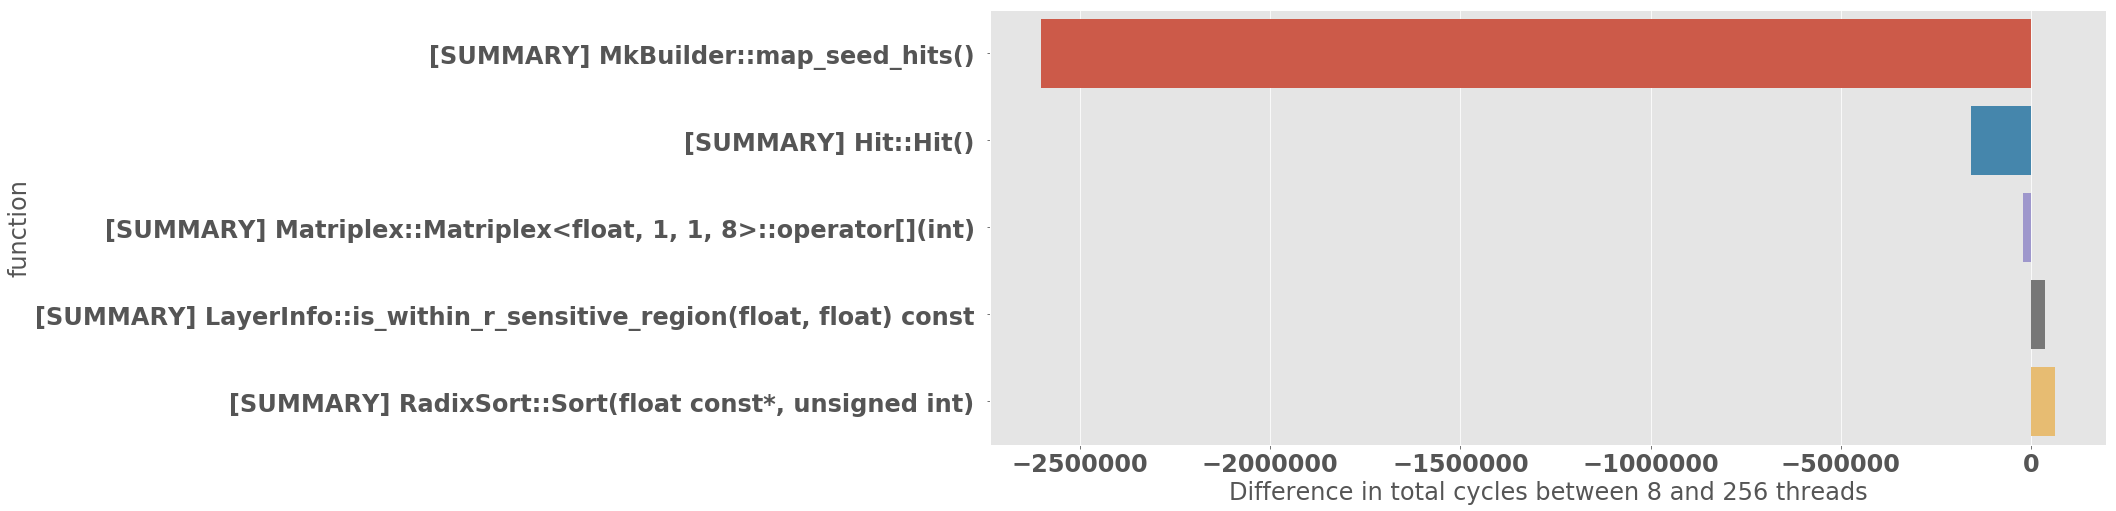

In [52]:
#thread_0 = expr_intervals['PAPI_TOT_CYC'].xs(0, level='thread').sort_values(by='Inclusive',ascending=False,axis=0)
METRIC='PAPI_TOT_CYC'

which='Inclusive'; inc = True; scaleByFractionOfTotal=True
thread_list, STL_PCT_data = scaling_plot(mdata, inclusive=inc, plot=False, metric=METRIC)
    
p = matplotlib.pyplot.plot(thread_list, STL_PCT_data,linewidth=3)
plt.xlabel('Number of Threads')
plt.ylabel(METRIC)

STL_PCT_data = select_metric_from_scaling(mdata, METRIC)

STL_PCT_dict = {}
tot_cyc = {}
for n_thr in thread_list:
    if not 'PAPI_TOT_CYC' in mdata[n_thr].keys(): continue
    mydata = combine_metrics(mdata[n_thr],inc_exc='Inclusive')
    for m in mdata[n_thr].keys():
        if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == METRIC): mydata.drop([m],axis=1,inplace=True)

    tot_cyc[n_thr] = mdata[n_thr]['PAPI_TOT_CYC'].groupby(['region']).mean()\
        .sort_values(by='Inclusive',ascending=False).query('region == "[SUMMARY] .TAU application"').head(1).iloc[0]['Inclusive']
    mydata['PERC_TOTAL'] = mydata['PAPI_TOT_CYC']/tot_cyc[n_thr]
    
    
    #if scaleByFractionOfTotal: # scaled by %total
    mydata[METRIC+'_Scaled'] = mydata[METRIC] * mydata['PERC_TOTAL'] 
    #STL_PCT_dict[n_thr] = mydata.groupby(['region']).mean().sort_values(by=['PAPI_TOT_CYC',METRIC],ascending=False).head(100)
    STL_PCT_data[n_thr] = filter_libs_out(mydata.groupby(['region']).mean())#.sort_values(by=METRIC+'_Scaled',ascending=False).head(100)
    print "Threads=",n_thr
    
    STL_PCT_dict[n_thr] = STL_PCT_data[n_thr]
    STL_PCT_dict[n_thr][which] = STL_PCT_dict[n_thr][METRIC+'_Scaled']
    highest10 = STL_PCT_dict[n_thr].sort_values(by=METRIC+'_Scaled',ascending=False)
    lowest10 = STL_PCT_dict[n_thr].sort_values(by=METRIC+'_Scaled',ascending=True)

print thread_list
#STL_PCT_dict=STL_PCT_data    

func = 'NULL';
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
dd = (STL_PCT_dict[8]-STL_PCT_dict[256])
#dd.sort_values(which, inplace=True)
#dd.drop_duplicates(subset=[which],keep='first',inplace=True)

sf = get_func_level_metric(dd, inclusive=inc, func=func, avg=False)

plt.figure() 
set_chart_font_size(24); plt.rcParams['figure.figsize']=(20,8)
sf['function'] = sf.index
sf = sf[~(sf['function'].str.contains('__GI__')|sf['function'].str.contains('_ZN9__gnu_cxx13')|
          sf['function'].str.contains('[CONTEXT]'))]
sf = sf[sf['function'].str.contains('::')]
sf = sf.sort_values(by=which,ascending=False).head(10)

#scalable_funcs.Function.apply(lambda x: x.replace('[SUMMARY] .TAU application',''))
g = sns.barplot(y='function',x=which,data=sf.head(5))

nf = dd.groupby(['region'])[[which]].sum().sort_values(by=which,ascending=True)[[which]]
plt.figure() ; set_chart_font_size(24); #plt.rcParams['figure.figsize']=(20,8)
nf['function'] = nf.index
nf = nf[~(nf['function'].str.contains('__GI__')|nf['function'].str.contains('_ZN9__gnu_cxx13')|
          nf['function'].str.contains('[CONTEXT]'))]
nf = nf[nf['function'].str.contains('::')]
nf = nf.sort_values(by=which,ascending=True).head(10)
plt.rcParams["axes.labelsize"] = 24
g = sns.barplot(y='function',x=which,data=nf.head(5))
plt.xlabel('Difference in total cycles between 8 and 256 threads')

nf[which].head(10)

(0, 0.12)

/shared/soft/taucmdr-enterprise/anaconda-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


Text(0.5,0,u'Threads')

Text(0,0.5,u'Miss rate')

(0, 0.12)

Text(0.5,0,u'Threads')

Text(0,0.5,u'Miss rate')

(0, 0.12)

Text(0.5,0,u'Threads')

Text(0,0.5,u'Miss rate')

(0, 0.12)

Text(0.5,0,u'Threads')

Text(0,0.5,u'Miss rate')

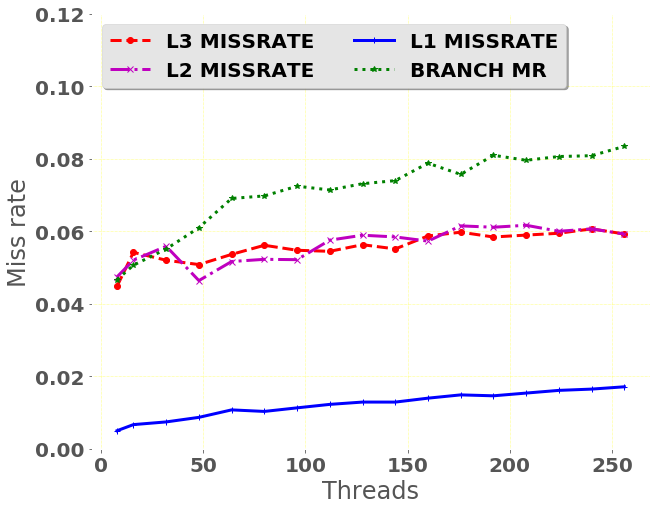

In [17]:
func = 'LayerInfo::is_within_r_sensitive_region'
#func = 'helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)'
func = 'NULL'

which='Inclusive';inc=True
matplotlib.rcParams.update({'font.size': 20})
set_chart_font_size(20);
plt.figure(figsize=(10,8))
df = pd.DataFrame()
#lines = {'DERIVED_VIPI':'yh--'}#,
lines = {'DERIVED_L1_MISSRATE':'b+-','DERIVED_L2_MISSRATE':'mx-.','DERIVED_L3_MISSRATE':'ro--','DERIVED_BRANCH_MR':'g*:'}

for METRIC, ls in lines.items():
    thread_list, data = scaling_plot(mdata, inclusive=inc, plot=False, metric=METRIC)
    p = matplotlib.pyplot.plot(thread_list, data, ls, linewidth=3, 
                               label=METRIC.replace('DERIVED_','').replace('_',' '))
    

    axes = plt.gca(); axes.set_ylim([0,0.12])
    
    axes.set_axis_bgcolor("white")
    axes.grid(linestyle=':', linewidth='0.5', color='yellow')
    leg = plt.legend(loc='upper left', ncol=2, shadow=True, fancybox=True)
    plt.xlabel('Threads')
    plt.ylabel('Miss rate')
    


    #data = select_metric_from_scaling(mdata, METRIC)
    #mdict = {}
    #for n_thr in thread_list:
    #    mdict[n_thr] = filter_libs_out(data[n_thr]).sort_values(by=which,ascending=False)[[which]]
    

In [76]:
names

{'DERIVED_BRANCH_MR': 'Branch misprediction rate',
 'DERIVED_CPI': 'Cycles per instruction',
 'DERIVED_IPC': 'Instructions per cycle',
 'DERIVED_L1_MISSRATE': 'L1 miss rate',
 'DERIVED_L3_MISSRATE': 'L3 miss rate',
 'DERIVED_STALL_PERCENT': 'Fraction of total stalls',
 'DERIVED_VIPC': 'Vector instructions per cycle',
 'DERIVED_VIPI': 'Vector instructions fraction',
 'PAPI_BR_CN': 'Conditional branches',
 'PAPI_BR_INS': 'Branch instructions',
 'PAPI_BR_MSP': 'Branch mispredictions',
 'PAPI_BR_UCN': 'Unconditional branches',
 'PAPI_L1_TCM': 'L1 total cache misses',
 'PAPI_L2_TCA': 'L2 accesses',
 'PAPI_L2_TCM': 'L2 total cache misses',
 'PAPI_LST_INS': 'Load/store instructions',
 'PAPI_NATIVE_LLC_MISSES': 'L3 misses',
 'PAPI_NATIVE_LLC_REFERENCES': 'L3 accesses',
 'PAPI_NATIVE_RS_FULL_STALL': 'Resource stalls',
 'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD': 'Vector operations',
 'PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD': 'Scalar operations using vector units',
 'PAPI_RES_STL': 'Total resource sta

region,Metric,[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkBuilder::map_seed_hits()
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,Scalar vector ops,1.04e-02
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,Vector operations,3.94e-02
PAPI_BR_CN,Conditional branches,1.13e-01
PAPI_BR_INS,Branch instructions,1.70e-01
PAPI_LST_INS,Load/store instructions,3.94e-01
PAPI_BR_UCN,Unconditional branches,5.04e-02
Other,Other,2.22e-01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7b830610>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'MkBuilder::map_seed_hits: Instruction Mix')

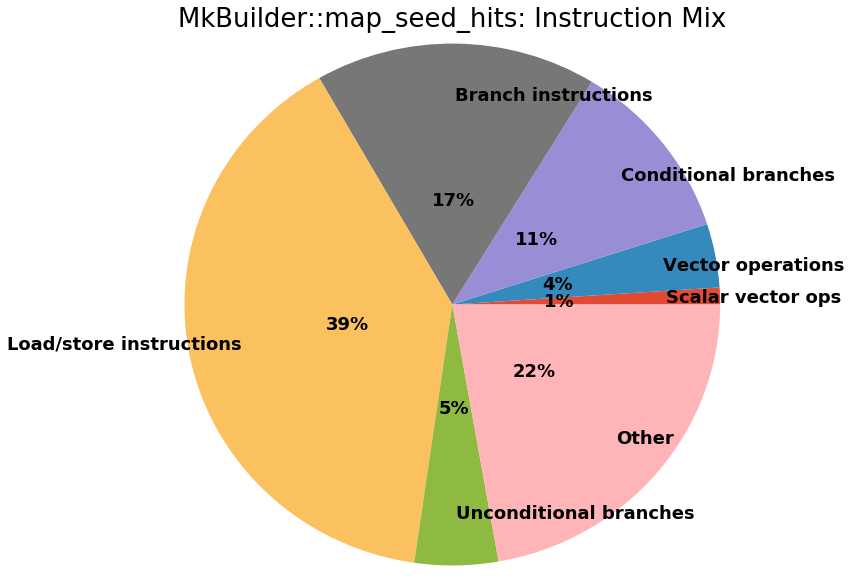

region,Metric,[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkBuilder::map_seed_hits()
PAPI_NATIVE_LLC_MISSES,L3 total cache misses,1.45e+05
PAPI_BR_MSP,Branch mispredictions,1.14e+06
PAPI_L2_TCM,L2 total cache misses,1.57e+05
PAPI_L1_TCM,L1 total cache misses,6.25e+05
PAPI_TLB_DM,TLB data misses,1.35e+05


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7bf4dc10>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'MkBuilder::map_seed_hits')

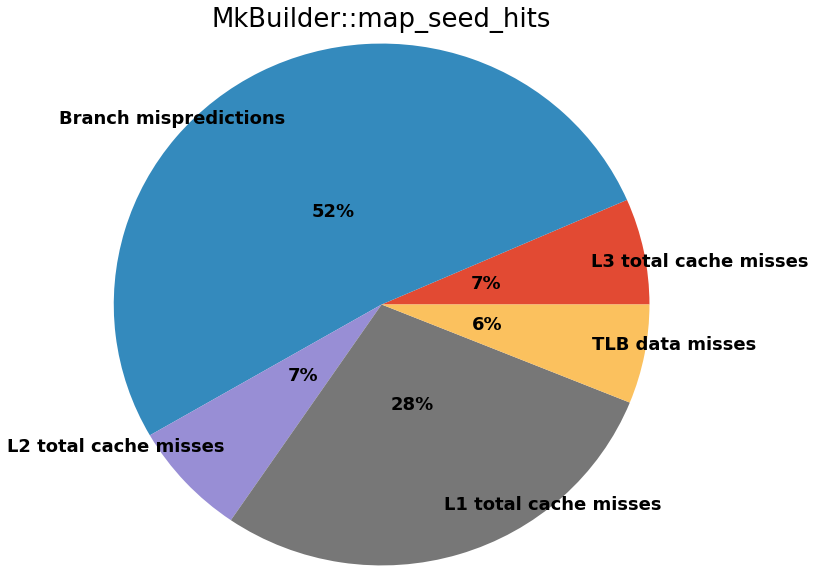

region,Metric,[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Hit::Hit()
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,Scalar vector ops,1.75e-01
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,Vector operations,nan
PAPI_BR_CN,Conditional branches,nan
PAPI_BR_INS,Branch instructions,nan
PAPI_LST_INS,Load/store instructions,nan
PAPI_BR_UCN,Unconditional branches,4.19e-02
Other,Other,7.83e-01


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7ba05790>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'Hit::Hit: Instruction Mix')

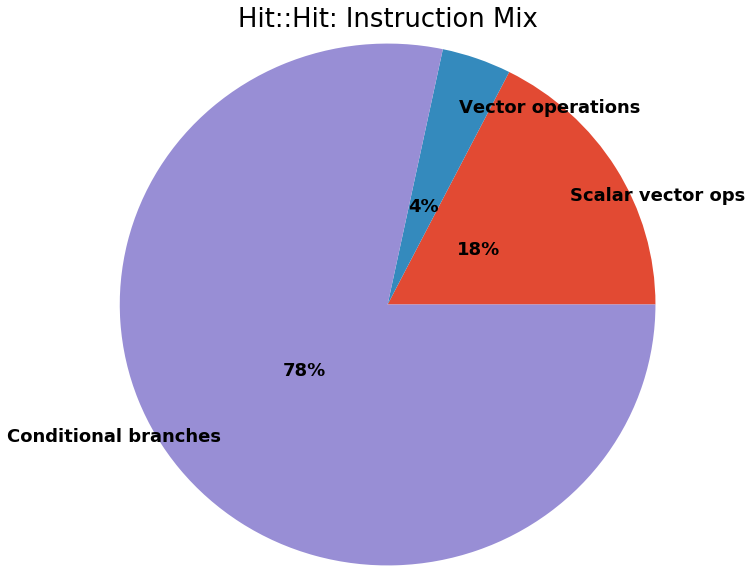

region,Metric,[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Hit::Hit()
PAPI_NATIVE_LLC_MISSES,L3 total cache misses,1.48e+04
PAPI_BR_MSP,Branch mispredictions,1.60e+04
PAPI_L2_TCM,L2 total cache misses,nan
PAPI_L1_TCM,L1 total cache misses,5.24e+04
PAPI_TLB_DM,TLB data misses,2.10e+04


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7a01dc50>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'Hit::Hit')

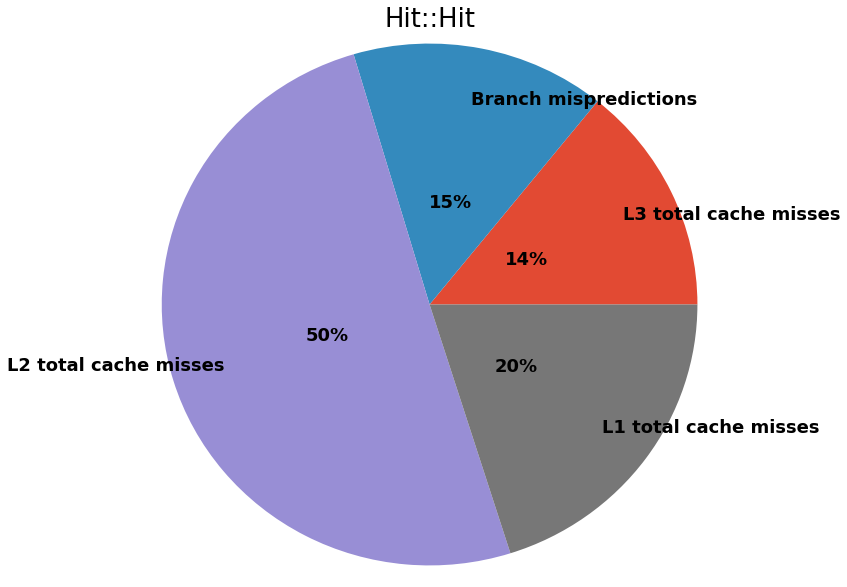

region,Metric,"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 1, 1, 8>::operator[](int)"
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,Scalar vector ops,nan
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,Vector operations,nan
PAPI_BR_CN,Conditional branches,nan
PAPI_BR_INS,Branch instructions,nan
PAPI_LST_INS,Load/store instructions,nan
PAPI_BR_UCN,Unconditional branches,nan
Other,Other,1.00e+00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7a044550>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'Matriplex::Matriplex<float, 1, 1, 8>::operator[]: Instruction Mix')

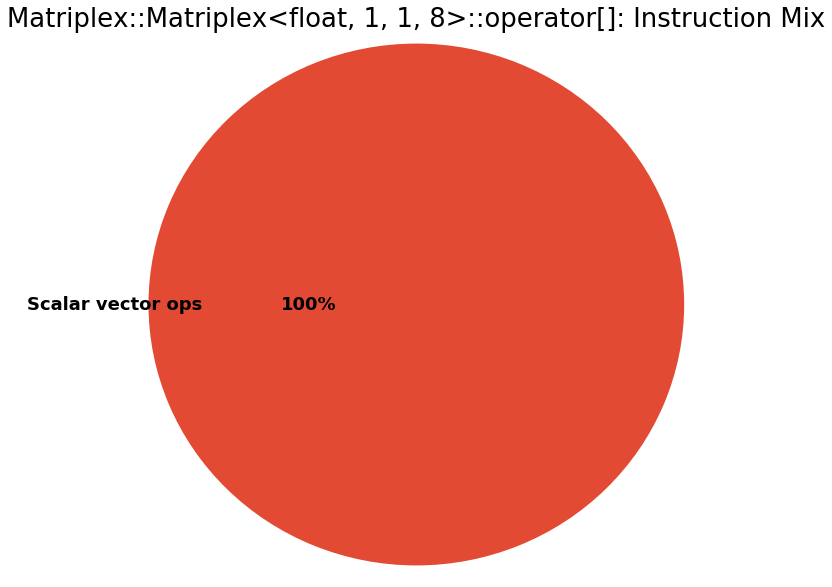

region,Metric,"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] Matriplex::Matriplex<float, 1, 1, 8>::operator[](int)"
PAPI_NATIVE_LLC_MISSES,L3 total cache misses,nan
PAPI_BR_MSP,Branch mispredictions,nan
PAPI_L2_TCM,L2 total cache misses,nan
PAPI_L1_TCM,L1 total cache misses,nan
PAPI_TLB_DM,TLB data misses,nan


region,Metric,"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)"
PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD,Scalar vector ops,1.89e-02
PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD,Vector operations,3.44e-01
PAPI_BR_CN,Conditional branches,8.80e-02
PAPI_BR_INS,Branch instructions,1.03e-01
PAPI_LST_INS,Load/store instructions,4.83e-01
PAPI_BR_UCN,Unconditional branches,1.63e-02
Other,Other,0.00e+00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba78215d10>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'MkFinder::SelectHitIndices: Instruction Mix')

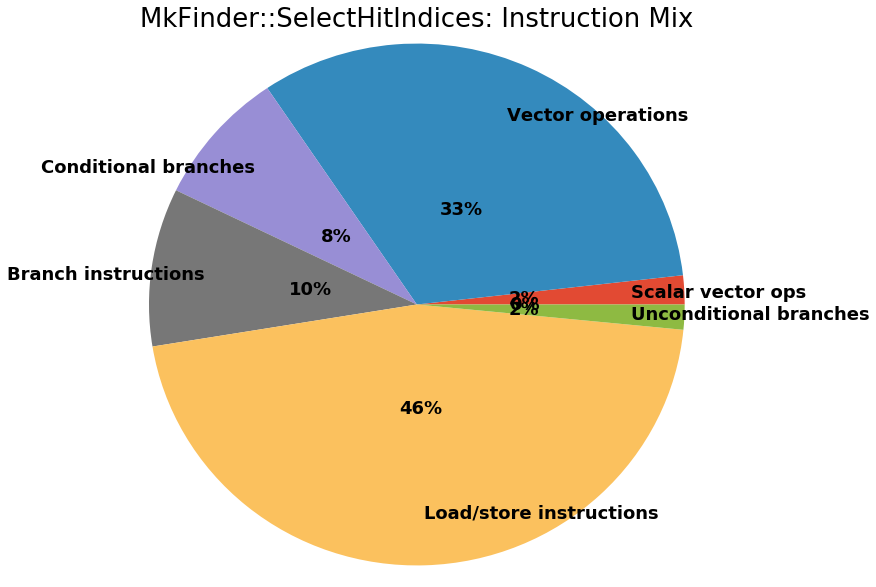

region,Metric,"[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] MkFinder::SelectHitIndices(LayerOfHits const&, int)"
PAPI_NATIVE_LLC_MISSES,L3 total cache misses,1.82e+04
PAPI_BR_MSP,Branch mispredictions,1.08e+05
PAPI_L2_TCM,L2 total cache misses,1.83e+04
PAPI_L1_TCM,L1 total cache misses,1.08e+05
PAPI_TLB_DM,TLB data misses,4.13e+04


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba7881ced0>], dtype=object)

Text(0,0.5,u'')

Text(0.5,1,u'MkFinder::SelectHitIndices')

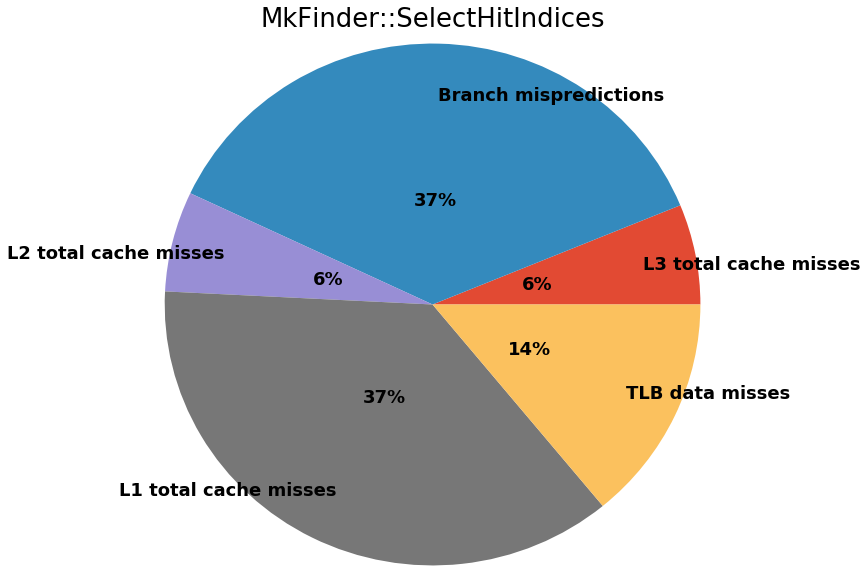

In [186]:
func = 'Matriplex::Matriplex<int, 1, 1, 8>::operator\[\]'
for func in ['MkBuilder::map_seed_hits','Hit::Hit','Matriplex::Matriplex<float, 1, 1, 8>::operator[]','MkFinder::SelectHitIndices']:
    incdata = combine_metrics(metric_data[256],inc_exc='Inclusive')
    set_chart_font_size(18);

    group_data = incdata.groupby(['region']).mean()
    #group_data.head()
    #group_data.reset_index(inplace=True)
    #group_data.head()
    #metric_list = group_data.mean().sort_values(by='PAPI_TOT_CYC',ascending=False)
    #fd = group_data[group_data['region'].str.contains(func,regex=False)]
    fd = group_data[group_data.index.get_level_values('region').str.contains(func,regex=False)]
    fd = fd.sort_values(by='PAPI_TOT_CYC',ascending=False)
    metrics1 = ['PAPI_NATIVE_UOPS_RETIRED:SCALAR_SIMD', 'PAPI_NATIVE_UOPS_RETIRED:PACKED_SIMD','PAPI_BR_CN',
                'PAPI_BR_INS',  'PAPI_LST_INS', 'PAPI_BR_UCN','PAPI_TOT_INS']
    metrics2 = ['PAPI_NATIVE_LLC_MISSES','PAPI_BR_MSP', 'PAPI_L2_TCM', 
                 'PAPI_L1_TCM', 'PAPI_TLB_DM']

    insmix = fd.head(1)[metrics1]
    for m in metrics1: insmix[m] = insmix[m]/insmix['PAPI_TOT_INS']
    insmix = insmix.drop('PAPI_TOT_INS',axis=1)
    insmix['Other'] = 1.0 - insmix.sum(axis=1)
    insmix = insmix.T; insmix[insmix<0]=0
    insmix.insert(0, 'Metric',pd.Series(names))
    insmix.rename(columns={func:'Value'}, inplace=True)
    #insmix = insmix.reset_index()[['Metric','Value']].set_index('Metric')
    insmix

    labels= insmix['Metric'].unique()
    insmix.dropna().plot.pie(subplots=True,figsize=(10, 10),labels=labels, legend=None,
                 autopct='%1.0f%%', pctdistance=0.4, labeldistance=0.8, radius=1.2)
    #plt.legend(loc="center left", fontsize=10)
    plt.ylabel(''); plt.title(func + ": Instruction Mix")
    plt.show()
    plt.savefig(func+'_insmix.png', dpi=72,transparent=True)


    bads = fd.head(1)[metrics2].T
    #for m in metrics2: insmix[m] = insmix[m]/insmix['PAPI_TOT_INS']
    bads.insert(0, 'Metric',pd.Series(names))
    bads.rename(columns={func:'Value'}, inplace=True)
    bads

    labels= bads['Metric'].unique()
    if not bads.dropna().empty:
        bads.dropna().plot.pie(subplots=True,figsize=(10, 10),labels=labels, legend=None,
                     autopct='%1.0f%%', pctdistance=0.4, labeldistance=0.8, radius=1.2)
        #plt.legend(loc="center left", fontsize=10)
        plt.ylabel(''); plt.title(func)
        plt.show()
        plt.savefig(func+'_counters.png', dpi=72,transparent=True)

# Store Buffer Stalls
<a id='stl_sb'></a>

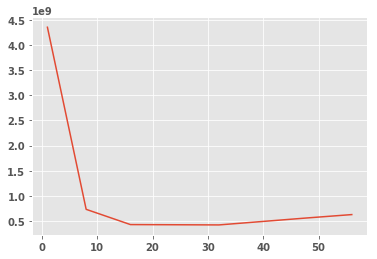

In [14]:
METRIC='PAPI_NATIVE_RESOURCE_STALLS:SB'
thread_list, STL_SB_data = scaling_plot(metric_data, plot=False, metric=METRIC)
    
plt = matplotlib.pyplot.plot(thread_list, STL_SB_data)

8


<BarContainer object of 8 artists>

(0.0, 5000000000.0)

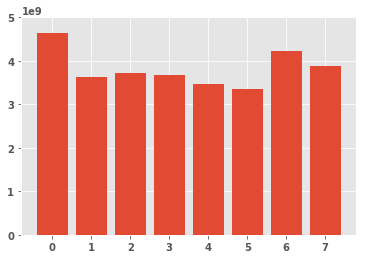

16


<BarContainer object of 16 artists>

(0.0, 5000000000.0)

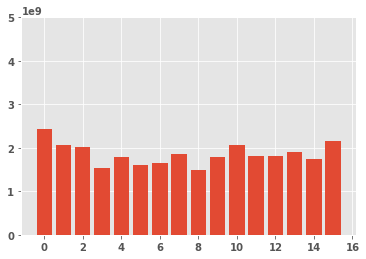

32


<BarContainer object of 32 artists>

(0.0, 5000000000.0)

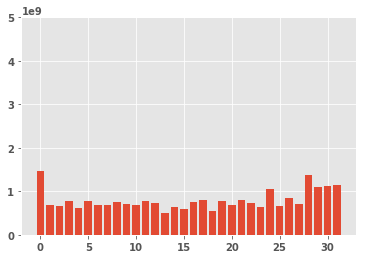

48


<BarContainer object of 48 artists>

(0.0, 5000000000.0)

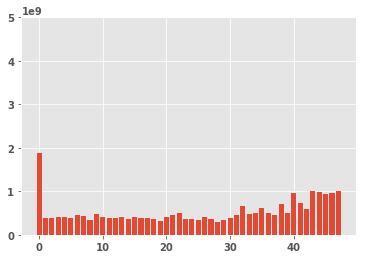

56


<BarContainer object of 56 artists>

(0.0, 5000000000.0)

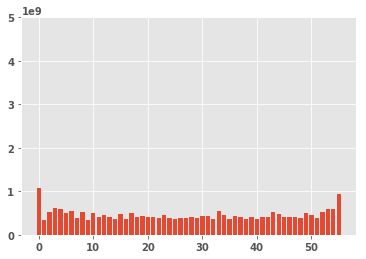

In [173]:
thread_STL_SB_data = get_thread_level_metric_scaling(metric_data, metric=METRIC)

for kt in thread_list:
    print kt
    data = list(thread_STL_SB_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=5e9)
    matplotlib.pyplot.show()

In [175]:
STL_SB_data = select_metric_from_scaling(metric_data, METRIC)
STL_SB_dict = {}
for n_thr in thread_list:
    STL_SB_dict[n_thr] = filter_libs_out(STL_SB_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[8, 16, 32, 48, 56]


In [178]:
THREAD_COUNT = 8
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(STL_SB_dict[THREAD_COUNT], func=func, avg=True).head(10)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.53e+07
[SUMMARY] __svml_sincosf8_l9,3.13e+07
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,2.78e+07
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",1.85e+07
[SUMMARY] __read_nocancel,1.40e+07
[SUMMARY] Event::clean_cms_seedtracks(),1.27e+07
"[SUMMARY] RadixSort::Sort(float const*, unsigned int)",1.20e+07
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",1.11e+07
"[SUMMARY] void _INTERNALc4f9cdd2::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<int, 1, 1, 8>, Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<float, 1, 1, 8>, Matriplex::Matriplex<float, 6, 6, 8> >(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, int, int, bool)",1.05e+07


In [180]:
stl_sb_data = copy.deepcopy(alldata)
metric = METRIC

for m in metric_data[THREAD_COUNT].keys():
    if (not m == 'METADATA') and (not m == 'PAPI_TOT_CYC') and (not m == metric): stl_sb_data.drop([m],axis=1,inplace=True)

def filter_libs_out(dfs):
    dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application =>' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
    return dfs_filtered        

stl_sb_data = stl_sb_data.groupby(['region']).mean().sort_values(by='PAPI_TOT_CYC',ascending=False).head(100)
stl_sb_data = filter_libs_out(stl_sb_data)
stl_sb_data = stl_sb_data[stl_sb_data.index.get_level_values('region').str.contains('::')]
# vipidata.sort_values(by=metric,ascending=True).head(20)
stl_sb_data.head(20)

,PAPI_TOT_CYC,PAPI_NATIVE_RESOURCE_STALLS:SB
region,,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",2.06e+08,1.27e+07
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",6.26e+07,3.50e+06
"[SUMMARY] Matriplex::MatriplexSym<float, 3, 8>::SlurpIn(char const*, int*, int)",4.44e+07,3.41e+06
"[SUMMARY] helixAtZ(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, bool)",3.67e+07,2.56e+06
[SUMMARY] Event::clean_cms_seedtracks(),3.47e+07,4.90e+05
"[SUMMARY] void _INTERNALc4f9cdd2::helixAtRFromIterativeCCS_impl<Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<int, 1, 1, 8>, Matriplex::Matriplex<float, 6, 1, 8>, Matriplex::Matriplex<float, 1, 1, 8>, Matriplex::Matriplex<float, 6, 6, 8> >(Matriplex::Matriplex<float, 6, 1, 8> const&, Matriplex::Matriplex<int, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 1, 8>&, Matriplex::Matriplex<float, 1, 1, 8> const&, Matriplex::Matriplex<float, 6, 6, 8>&, int, int, int, bool)",3.24e+07,2.11e+06
"[SUMMARY] (anonymous namespace)::sortCandListByHitsChi2(MkFinder::IdxChi2List const&, MkFinder::IdxChi2List const&)",3.15e+07,1.67e+06
"[SUMMARY] Matriplex::MatriplexSym<float, 6, 8>::CopyIn(int, float const*)",2.99e+07,1.79e+06
[SUMMARY] Track::Track(Track const&),2.83e+07,1.08e+06


## L2 Miss Count
<a id='l2'></a>

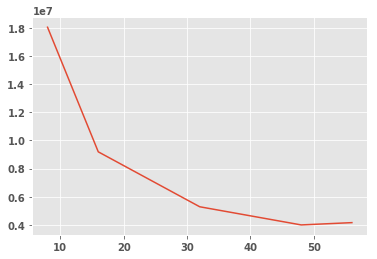

In [158]:
thread_list, L2_TCM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L2_TCM')
    
plt = matplotlib.pyplot.plot(thread_list, L2_TCM_data)

8


<BarContainer object of 8 artists>

(0.0, 500000000.0)

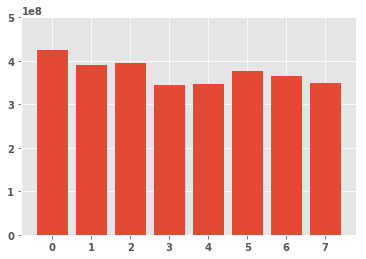

16


<BarContainer object of 16 artists>

(0.0, 500000000.0)

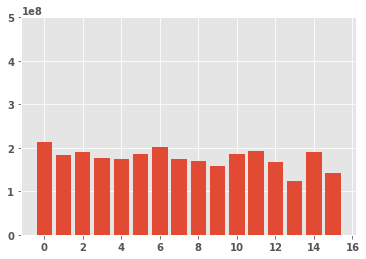

32


<BarContainer object of 32 artists>

(0.0, 500000000.0)

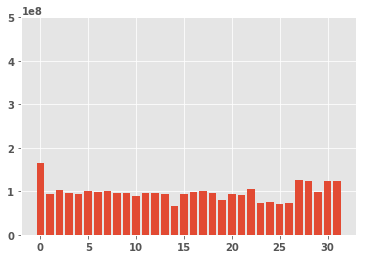

48


<BarContainer object of 48 artists>

(0.0, 500000000.0)

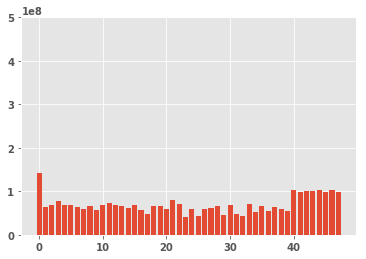

56


<BarContainer object of 56 artists>

(0.0, 500000000.0)

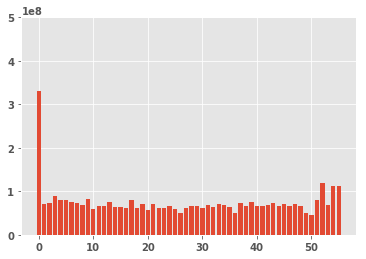

In [162]:
thread_L2_TCM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L2_TCM')

for kt in thread_list:
    print kt
    data = list(thread_L2_TCM_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=5e8)
    matplotlib.pyplot.show()

In [164]:
L2_TCM_data = select_metric_from_scaling(metric_data, 'PAPI_L2_TCM')
L2_TCM_dict = {}
for n_thr in thread_list:
    L2_TCM_dict[n_thr] = filter_libs_out(L2_TCM_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[8, 16, 32, 48, 56]


In [165]:
THREAD_COUNT = 16
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L2_TCM_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",1.87e+06
[SUMMARY] __svml_sincosf8_l9,1.25e+06
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,1.14e+06
[SUMMARY] __GI___libc_malloc,9.06e+05
"[SUMMARY] MkFinder::FindCandidatesCloneEngine(LayerOfHits const&, CandCloner&, int, int, FindingFoos const&)",6.57e+05
[SUMMARY] __read_nocancel,6.33e+05
[SUMMARY] Event::clean_cms_seedtracks(),6.28e+05
[SUMMARY] _int_free,5.94e+05
[SUMMARY] __intel_avx_rep_memset,4.59e+05


## L3 Miss Count
<a id='l3'></a>

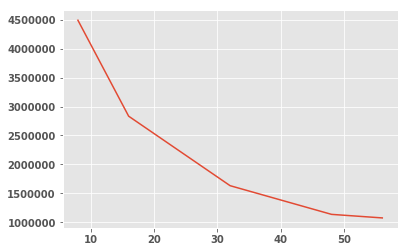

In [149]:
thread_list, L3_TCM_data = scaling_plot(metric_data, plot=False, metric='PAPI_L3_TCM')
    
plt = matplotlib.pyplot.plot(thread_list, L3_TCM_data)

8


<BarContainer object of 8 artists>

(0.0, 200000000.0)

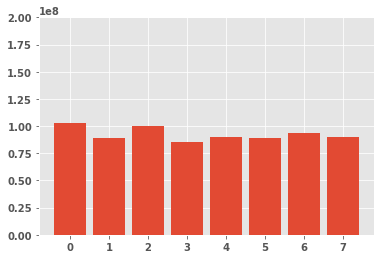

16


<BarContainer object of 16 artists>

(0.0, 200000000.0)

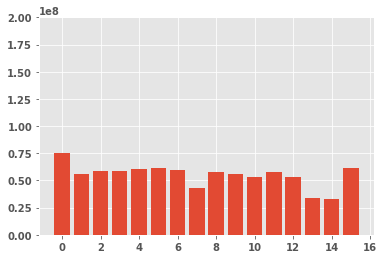

32


<BarContainer object of 32 artists>

(0.0, 200000000.0)

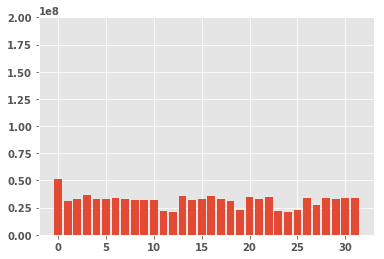

48


<BarContainer object of 48 artists>

(0.0, 200000000.0)

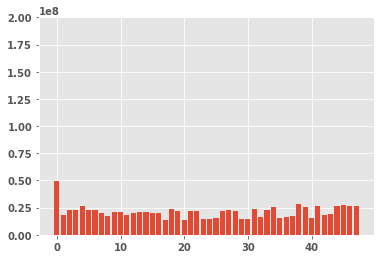

56


<BarContainer object of 56 artists>

(0.0, 200000000.0)

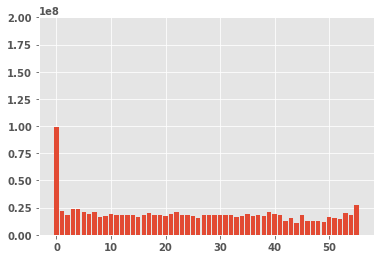

In [156]:
thread_L3_TCM_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_L3_TCM')

for kt in thread_list:
    print kt
    data = list(thread_L3_TCM_data[kt])
    matplotlib.pyplot.bar(range(len(data)), data)
    matplotlib.pyplot.ylim(ymax=2e8)
    matplotlib.pyplot.show()

In [153]:
L3_TCM_data = select_metric_from_scaling(metric_data, 'PAPI_L3_TCM')
L3_TCM_dict = {}
for n_thr in thread_list:
    L3_TCM_dict[n_thr] = filter_libs_out(L3_TCM_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
print thread_list

[8, 16, 32, 48, 56]


In [157]:
THREAD_COUNT = 16
func = 'NULL'
# func = 'FindCandidatesCloneEngine' # NULL for nothing
# func = 'SelectHitIndices' # NULL for nothing
get_func_level_metric(L3_TCM_dict[THREAD_COUNT], func=func, avg=True).head(20)

,Exclusive
region,
"[SUMMARY] MkFinder::SelectHitIndices(LayerOfHits const&, int)",4.96e+05
[SUMMARY] Event::clean_cms_seedtracks(),3.08e+05
[SUMMARY] __svml_sincosf8_l9,2.90e+05
[SUMMARY] .TAU application => [CONTEXT] .TAU application => [SAMPLE] __svml_sincosf8_l9,2.61e+05
[SUMMARY] __GI___libc_malloc,2.52e+05
[SUMMARY] __read_nocancel,2.31e+05
[SUMMARY] _int_free,2.05e+05
"[SUMMARY] RadixSort::Sort(float const*, unsigned int)",1.85e+05
[SUMMARY] _int_malloc,1.77e+05


## Fetch Stalls
<a id='fetch_stalls'></a>

In [116]:
# thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
    
# plt = matplotlib.pyplot.plot(thread_list, FETCH_STALL_data)

In [117]:
# thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

# for kt in thread_list:
#     print kt
#     data = list(thread_FETCH_STL_data[kt])
#     matplotlib.pyplot.bar(range(len(data)), data)
#     matplotlib.pyplot.ylim(ymax=2e9)
#     matplotlib.pyplot.show()

In [118]:
# FS_data = select_metric_from_scaling(metric_data, 'PAPI_NATIVE_FETCH_STALL')
# FS_dict = {}
# for n_thr in thread_list:
#     FS_dict[n_thr] = filter_libs_out(FS_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# print thread_list

In [119]:
# THREAD_COUNT = 1
# func = 'NULL'
# # func = 'FindCandidatesCloneEngine' # NULL for nothing
# # func = 'SelectHitIndices' # NULL for nothing
# get_func_level_metric(FS_dict[THREAD_COUNT], func=func, avg=True).head(20)

## Stalls per Cycle
<a id='fetch_ratio'></a>

In [120]:
# thread_list, FETCH_STALL_data = scaling_plot(metric_data, plot=False, metric='PAPI_NATIVE_FETCH_STALL')
# thread_list, TOT_CYC_data = scaling_plot(metric_data, plot=False, metric='PAPI_TOT_CYC')
    
# FS_P_CYC_list = [FETCH_STALL_data[i] / TOT_CYC_data[i] for i in range(len(thread_list))]

# plt = matplotlib.pyplot.plot(thread_list, FS_P_CYC_list)

In [121]:
# thread_TOT_CYC_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_TOT_CYC')
# thread_FETCH_STL_data = get_thread_level_metric_scaling(metric_data, metric='PAPI_NATIVE_FETCH_STALL')

# FS_P_CYC_data = {}
# for kt in thread_list:
# #     print(thread_L1M_data[kt])
# #     print(thread_L1A_data[kt])
#     FS_P_CYC_data[kt] = thread_FETCH_STL_data[kt] / thread_TOT_CYC_data[kt]
     
# for kt in thread_list:
#     print kt
#     data = list(FS_P_CYC_data[kt])
#     matplotlib.pyplot.bar(range(len(data)), data)
#     matplotlib.pyplot.ylim(ymax=0.2)
#     matplotlib.pyplot.show()

In [122]:
# FSTC_data = select_metric_from_scaling(metric_data, 'DERIVED_RATIO_FETCH_STL_TOT_CYC')
# FSTC_dict = {}


# def filter_libs_out_2(dfs):
#     dfs_filtered = dfs.groupby(level='region').filter(lambda x: ('.TAU application ' not in x.name) and ('tbb' not in x.name) and ('syscall' not in x.name)  and ('std::' not in x.name))
#     return dfs_filtered

# for n_thr in thread_list:
#     FSTC_dict[n_thr] = filter_libs_out_2(FSTC_data[n_thr]).sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# #     FSTC_dict[n_thr] = FSTC_data[n_thr].sort_values(by='Exclusive',ascending=False)[["Exclusive"]]
# print thread_list

In [123]:
# THREAD_COUNT = 32
# func = 'NULL'
# # func = 'FindCandidatesCloneEngine' # NULL for nothing
# # func = 'SelectHitIndices' # NULL for nothing
# get_func_level_metric(FSTC_dict[THREAD_COUNT], func=func, avg=True).head(10)